In [38]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Load JSON data
with open('data/watch-history.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.json_normalize(data)

# Show the first few rows
df.head()

,header,title,titleUrl,time,products,activityControls,subtitles
0,YouTube,Watched https://www.youtube.com/watch?v=CEaKz0...,https://www.youtube.com/watch?v=CEaKz0S_25I,2025-07-28T18:29:14.363Z,[YouTube],[YouTube watch history],NaN
1,YouTube,Watched https://www.youtube.com/watch?v=7nQsQ0...,https://www.youtube.com/watch?v=7nQsQ0rvYqQ,2025-07-28T18:28:49.335Z,[YouTube],[YouTube watch history],NaN
2,YouTube,Watched https://www.youtube.com/watch?v=JFYS-P...,https://www.youtube.com/watch?v=JFYS-PucOH0,2025-07-28T18:28:26.700Z,[YouTube],[YouTube watch history],NaN
3,YouTube,Watched https://www.youtube.com/watch?v=cpde-l...,https://www.youtube.com/watch?v=cpde-lI7_pE,2025-07-28T14:37:18.975Z,[YouTube],[YouTube watch history],NaN
4,YouTube,Watched https://www.youtube.com/watch?v=buMGni...,https://www.youtube.com/watch?v=buMGniVNc6s,2025-07-28T14:37:09.886Z,[YouTube],[YouTube watch history],NaN


In [40]:
df.columns

Index(['header', 'title', 'titleUrl', 'time', 'products', 'activityControls',
       'subtitles'],
      dtype='object')

In [41]:
#Change the time format 
df['time'] = pd.to_datetime(df['time'], format='ISO8601', errors='coerce', utc=True)


In [42]:
# Extract useful time features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['weekday'] = df['time'].dt.day_name()   # Saturday, Sunday,....etc
df['hour'] = df['time'].dt.hour

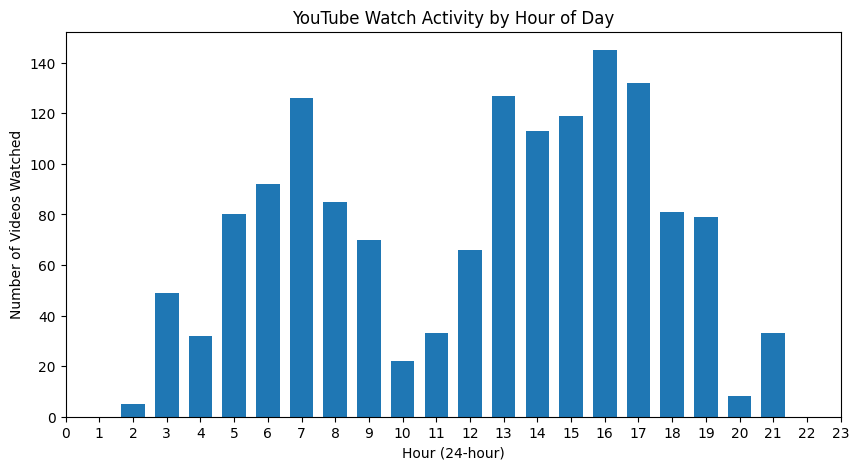

In [43]:
#visualization of watch hours during the day
watch_by_hour = df['hour'].value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.bar(watch_by_hour.index, watch_by_hour.values, align='center', width=0.7)
plt.xticks(range(24))
plt.xlabel('Hour (24-hour)')
plt.ylabel('Number of Videos Watched')
plt.title('YouTube Watch Activity by Hour of Day')
plt.show()


In [44]:
#count of watched videos on weekdays(sorted)
watch_by_weekday = df['weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

print(watch_by_weekday)

weekday
Monday       222
Tuesday      201
Wednesday    337
Thursday     240
Friday       193
Saturday     157
Sunday       147
Name: count, dtype: int64


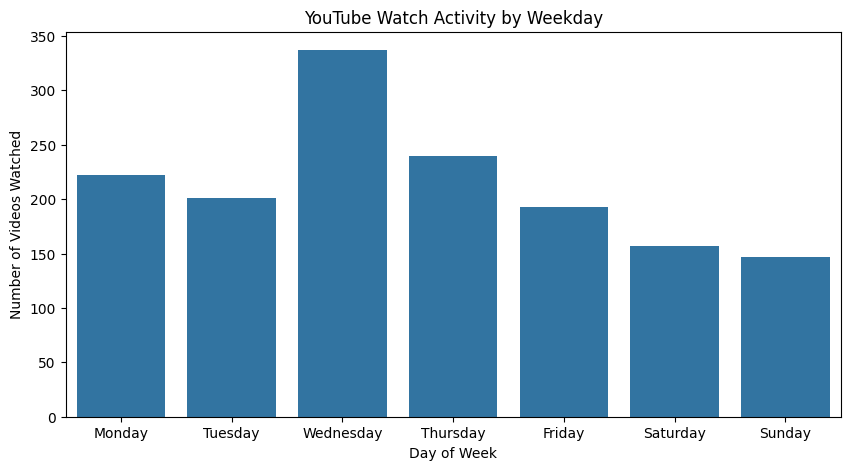

In [45]:
#Visualization of watch activity by weekday
df['weekday'] = df['time'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
watch_by_weekday = df['weekday'].value_counts().reindex(weekday_order)

# Plot using seaborn with categorical x-axis
plt.figure(figsize=(10,5))
sns.barplot(x=watch_by_weekday.index, y=watch_by_weekday.values)
plt.xlabel('Day of Week')
plt.ylabel('Number of Videos Watched')
plt.title('YouTube Watch Activity by Weekday')
plt.show()


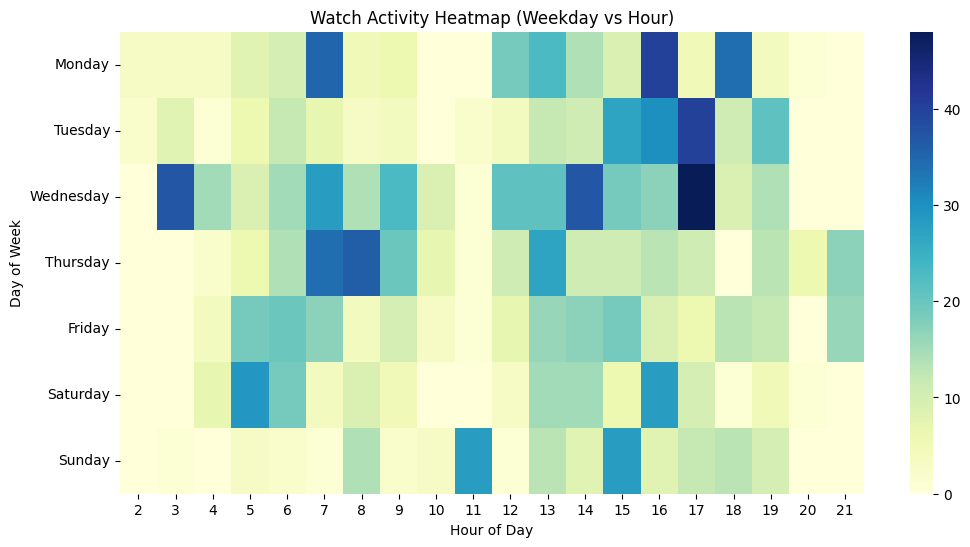

In [46]:
#Heatmap of weekday and hour
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

# Reorder weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(weekday_order)

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Watch Activity Heatmap (Weekday vs Hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


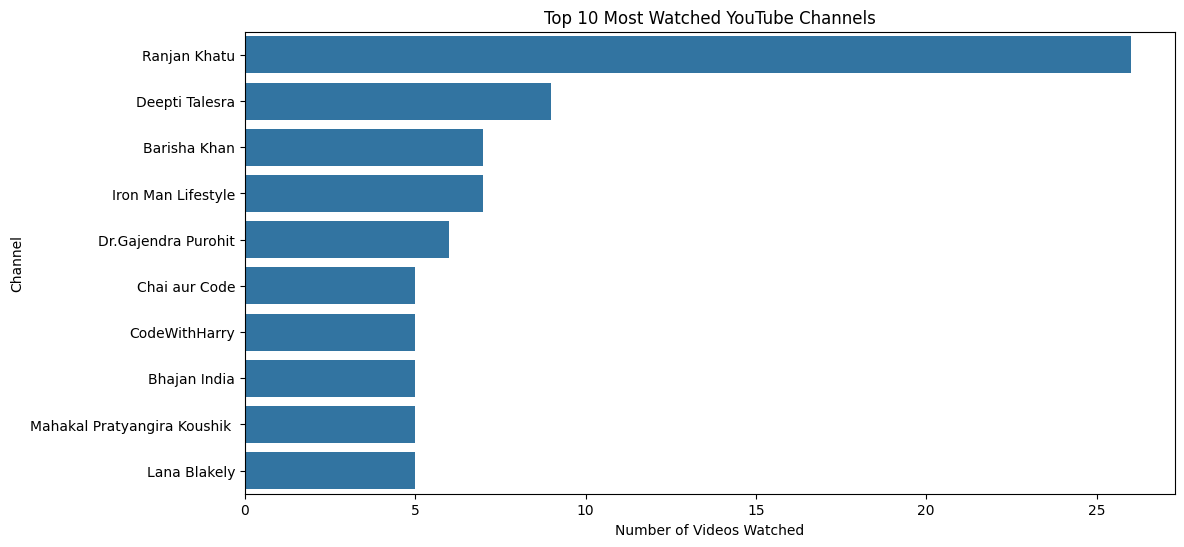

In [47]:
# Top 10 channels that you watch
def get_channel(subtitles):
    if isinstance(subtitles, list) and len(subtitles) > 0:
        return subtitles[0].get('name', None)
    else:
        return None

df['channel'] = df['subtitles'].apply(get_channel)

# Now count top channels
top_channels = df['channel'].value_counts().head(10)

# Plot top channels
plt.figure(figsize=(12,6))
sns.barplot(x=top_channels.values, y=top_channels.index)
plt.xlabel('Number of Videos Watched')
plt.ylabel('Channel')
plt.title('Top 10 Most Watched YouTube Channels')
plt.show()


In [48]:
# Total number of videos watched
total_videos = len(df)
print(f"Total videos watched: {total_videos}")

# Date range of watch history
start_date = df['time'].min()
end_date = df['time'].max()
print(f"Watch history from {start_date.date()} to {end_date.date()}")

# Average videos watched per day
videos_per_day = df.groupby(df['time'].dt.date).size()
avg_per_day = videos_per_day.mean()
print(f"Average videos watched per day: {avg_per_day:.2f}")

Total videos watched: 1497
Watch history from 2025-03-06 to 2025-07-28
Average videos watched per day: 11.98


C:\Users\biswa\AppData\Local\Temp\ipykernel_15080\102822407.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts = df.groupby(df['time'].dt.to_period('M')).size()


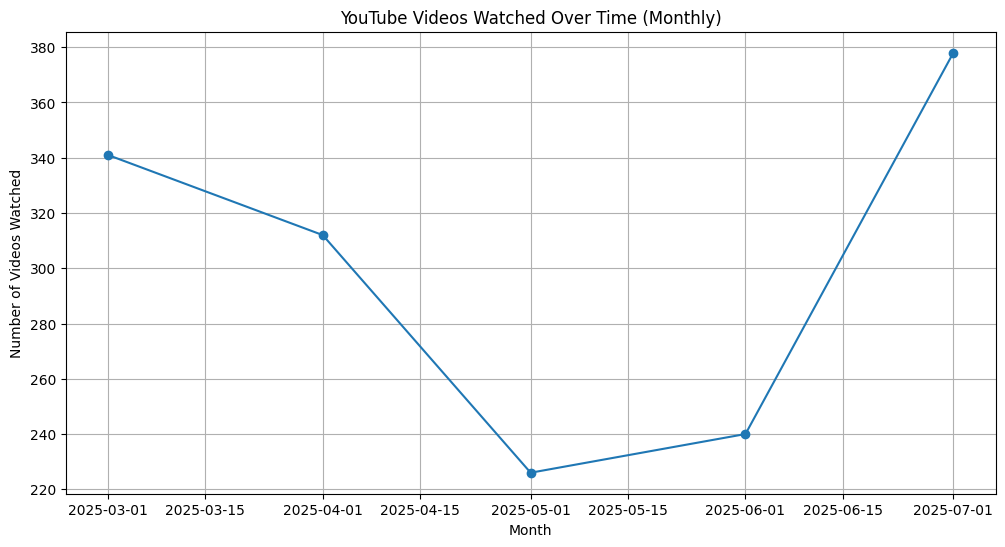

In [49]:
#monthly count of watched videos
monthly_counts = df.groupby(df['time'].dt.to_period('M')).size()

monthly_counts.index = monthly_counts.index.to_timestamp()

plt.figure(figsize=(12,6))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title('YouTube Videos Watched Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Number of Videos Watched')
plt.grid(True)
plt.show()


In [50]:
# Average of watched videos in one go

# Sort by time
df_sorted = df.sort_values('time').reset_index(drop=True)

# Calculate time difference between consecutive videos (in minutes)
df_sorted['time_diff'] = df_sorted['time'].diff().dt.total_seconds().div(60)

# Define a new session if gap is more than 30 minutes
df_sorted['new_session'] = (df_sorted['time_diff'] > 30).cumsum()

# Session lengths (number of videos per session)
session_lengths = df_sorted.groupby('new_session').size()

print(f"Average videos per session: {session_lengths.mean():.2f}")
print(f"Number of sessions: {session_lengths.count()}")


Average videos per session: 4.02
Number of sessions: 372


In [51]:
# watch count by hours
hourly_counts = df.groupby('hour').size()
weekday_counts = df['weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

print("Watch counts by hour:")
print(hourly_counts)

print("\nWatch counts by weekday:")
print(weekday_counts)


Watch counts by hour:
hour
2       5
3      49
4      32
5      80
6      92
7     126
8      85
9      70
10     22
11     33
12     66
13    127
14    113
15    119
16    145
17    132
18     81
19     79
20      8
21     33
dtype: int64

Watch counts by weekday:
weekday
Monday       222
Tuesday      201
Wednesday    337
Thursday     240
Friday       193
Saturday     157
Sunday       147
Name: count, dtype: int64


In [52]:
def busiest_watch_times(df):
    # Aggregate watch counts by hour and weekday
    hourly_counts = df.groupby('hour').size()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_counts = df['weekday'].value_counts().reindex(weekday_order)

    busiest_hour = hourly_counts.idxmax()
    busiest_day = weekday_counts.idxmax()

    print(f"Your busiest watch hour is: {busiest_hour}:00 - {busiest_hour+1}:00")
    print(f"Your busiest watch day is: {busiest_day}")
    return busiest_hour, busiest_day

def suggest_watch_times(busiest_hour, busiest_day):
    print(f"Based on your history, you are most active on {busiest_day}s around {busiest_hour}:00.")
    print("Consider scheduling your study or leisure watching around these times!")

def plot_moving_average(df, window=7):
    daily_counts = df.set_index('time').resample('D').size()
    moving_avg = daily_counts.rolling(window=window).mean()

    plt.figure(figsize=(12,6))
    plt.plot(daily_counts.index, daily_counts.values, label='Daily Counts')
    plt.plot(moving_avg.index, moving_avg.values, label=f'{window}-Day Moving Average', linewidth=3)
    plt.title('Daily Watch Counts with Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Number of Videos Watched')
    plt.legend()
    plt.show()

def top_channels_and_videos(df, top_n=5):
    top_channels = df['channel'].value_counts().head(top_n)
    top_videos = df['title'].value_counts().head(top_n)

    print(f"Top {top_n} Channels You Watch:")
    print(top_channels)
    print("\nTop {top_n} Videos You Watch:")
    print(top_videos)
    
    return top_channels, top_videos



In [53]:
# 1. Find busiest watch times
hour, day = busiest_watch_times(df)


Your busiest watch hour is: 16:00 - 17:00
Your busiest watch day is: Wednesday


In [54]:
# 2. Suggest watch times
suggest_watch_times(hour, day)

Based on your history, you are most active on Wednesdays around 16:00.
Consider scheduling your study or leisure watching around these times!


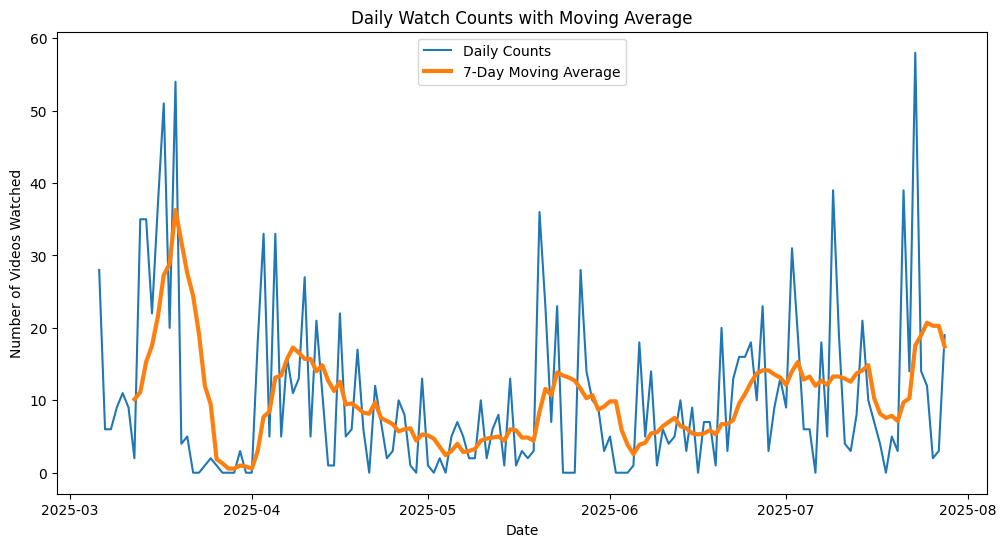

In [55]:
# 3. Plot moving average of daily watches
plot_moving_average(df)

In [56]:
# 4. Print top channels and videos
top_channels, top_videos = top_channels_and_videos(df)

Top 5 Channels You Watch:
channel
Ranjan Khatu           26
Deepti Talesra          9
Barisha Khan            7
Iron Man Lifestyle      7
Dr.Gajendra Purohit     6
Name: count, dtype: int64

Top {top_n} Videos You Watch:
title
Watched https://www.youtube.com/watch?v=CEaKz0S_25I    11
Watched https://www.youtube.com/watch?v=vseQ2aw2r54     9
Watched https://www.youtube.com/watch?v=n3Vpfdxz-m8     7
Watched https://www.youtube.com/watch?v=oec7CXRAfeE     6
Watched https://www.youtube.com/watch?v=VJ-o8y8JqCQ     6
Name: count, dtype: int64
